### Aim:
In this notebook, the effect of combining two best-performing models (logistic regression and SVM) for "mostDILI" predictions via a voting classifier will be evaluated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, 

In [2]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read in datasets, prepare data for ML

In [3]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [4]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [5]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [6]:
## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=12)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=12)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=12)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

True

True

### Voting Classifier - 
#### based on logistic regression and SVM (two best performing algorithms) with optimized parameters for each algorithm

In [7]:
#Instantiate voting classifier based on optimal parameters for logistic and SVM models

log_mc=LogisticRegression(class_weight='balanced')
log_tc=LogisticRegression(class_weight='balanced')
log_mctc=LogisticRegression(class_weight='balanced')


svm_mc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=2, random_state = 1)
svm_tc = SVC(kernel='linear',probability=True, class_weight='balanced', gamma=1e-06,C=1, random_state = 1)
svm_mctc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=0.5, random_state = 1)


vot_clf_mc=VotingClassifier(estimators=[('log_mc', log_mc), ('svm_mc', svm_mc)], voting='soft', weights=[1,.25])
vot_clf_tc=VotingClassifier(estimators=[('log_tc', log_tc), ('svm_tc', svm_tc)], voting='soft', weights=[1,.25])
vot_clf_mctc=VotingClassifier(estimators=[('log_mctc', log_mctc), ('svm_mctc', svm_mctc)], voting='soft', weights=[1,.25])

In [8]:
#Fit to instntiated voting classifiers

vot_clf_mc.fit(train_mcx, train_mcy)
vot_clf_tc.fit(train_tcx, train_tcy)
vot_clf_mctc.fit(train_mctcx, train_mctcy)

VotingClassifier(estimators=[('log_mc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('sv...ear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.25])

VotingClassifier(estimators=[('log_tc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('sv...ear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.25])

VotingClassifier(estimators=[('log_mctc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('...ear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.25])

In [9]:
#Predict test_y values and probabilities for each dataset based on voting classifiers model from above

#Using voting classifier model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
vot_clf_pred_mcy=vot_clf_mc.predict(test_mcx) 
vot_clf_probs_mcy=vot_clf_mc.predict_proba(test_mcx) 

### Using voting classifier model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
vot_clf_pred_tcy=vot_clf_tc.predict(test_tcx) 
vot_clf_probs_tcy=vot_clf_tc.predict_proba(test_tcx) 


### Using voting classifier model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
vot_clf_pred_mctcy=vot_clf_mctc.predict(test_mctcx) 
vot_clf_probs_mctcy=vot_clf_mctc.predict_proba(test_mctcx) 

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Performance metrics of voting classifier models fitted on test-train splits

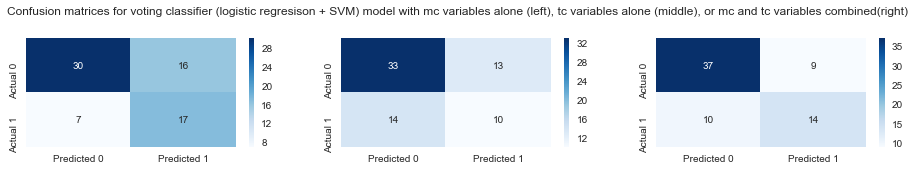

In [10]:
### Confusion Matrix
vot_clf_cfm_mc=metrics.confusion_matrix(test_mcy, vot_clf_pred_mcy)
vot_clf_cfm_tc=metrics.confusion_matrix(test_tcy, vot_clf_pred_tcy)
vot_clf_cfm_mctc=metrics.confusion_matrix(test_mctcy, vot_clf_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(vot_clf_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(vot_clf_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(vot_clf_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for voting classifier (logistic regresison + SVM) model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [11]:
### Precision, Recall

vot_clf_cr_mc=metrics.classification_report(test_mcy, vot_clf_pred_mcy)
vot_clf_cr_tc=metrics.classification_report(test_tcy, vot_clf_pred_tcy)
vot_clf_cr_mctc=metrics.classification_report(test_mctcy, vot_clf_pred_mctcy)

print("precision_recall for model with mc variables alone")
print(vot_clf_cr_mc)

print("precision_recall for model with tc variables alone")
print(vot_clf_cr_tc)

print("precision_recall for model with mc&tc variables combined")
print(vot_clf_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.81      0.65      0.72        46
          1       0.52      0.71      0.60        24

avg / total       0.71      0.67      0.68        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.70      0.72      0.71        46
          1       0.43      0.42      0.43        24

avg / total       0.61      0.61      0.61        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.79      0.80      0.80        46
          1       0.61      0.58      0.60        24

avg / total       0.73      0.73      0.73        70



In [12]:
### Accuracy
vot_clf_acc_mc=round(metrics.accuracy_score(test_mcy, vot_clf_pred_mcy), 2)
print("Overall accuracy with mc dataset @ default threshold: " + str(vot_clf_acc_mc)+"\n")

vot_clf_acc_tc=round(metrics.accuracy_score(test_mcy, vot_clf_pred_tcy), 2)
print("Overall accuracy with tc dataset @ default threshold: " + str(vot_clf_acc_tc)+"\n")

vot_clf_acc_mctc=round(metrics.accuracy_score(test_mctcy,vot_clf_pred_mctcy), 2)
print("Overall accuracy with mctc dataset @ default threshold: " + str(vot_clf_acc_mctc)+"\n")

Overall accuracy with mc dataset @ default threshold: 0.67

Overall accuracy with tc dataset @ default threshold: 0.61

Overall accuracy with mctc dataset @ default threshold: 0.73



In [13]:
###Specificity
from sklearn.metrics import confusion_matrix

tn_mc, fp_mc, fn_mc, tp_mc = confusion_matrix(test_mcy, vot_clf_pred_mcy).ravel()
specificity_mc = tn_mc / (tn_mc+fp_mc)
print("Specificity for model with mc variables alone")
round(specificity_mc,3)


tn_tc, fp_tc, fn_tc, tp_tc = confusion_matrix(test_tcy, vot_clf_pred_tcy).ravel()
specificity_tc = tn_tc / (tn_tc+fp_tc)
print("Specificity for model with tc variables alone")
round(specificity_tc,3)

tn_mctc, fp_mctc, fn_mctc, tp_mctc = confusion_matrix(test_mctcy, vot_clf_pred_mctcy).ravel()
specificity_mctc = tn_mctc / (tn_mctc+fp_mctc)
print("Specificity for model with mctc variables")
round(specificity_mctc, 3)

Specificity for model with mc variables alone


0.652

Specificity for model with tc variables alone


0.717

Specificity for model with mctc variables


0.804

#### Roc curve analysis

In [14]:
#calculate values to populate ROC curve

vot_clf_fpr_mc,vot_clf_tpr_mc, vot_clf_thresholds_mc=roc_curve(test_mcy, vot_clf_probs_mcy[:, 1])
vot_clf_roc_auc_mc=metrics.auc(vot_clf_fpr_mc, vot_clf_tpr_mc)

vot_clf_fpr_tc,vot_clf_tpr_tc, vot_clf_thresholds_tc=roc_curve(test_tcy, vot_clf_probs_tcy[:, 1])
vot_clf_roc_auc_tc=metrics.auc(vot_clf_fpr_tc, vot_clf_tpr_tc)

vot_clf_fpr_mctc,vot_clf_tpr_mctc, vot_clf_thresholds_mctc=roc_curve(test_mctcy, vot_clf_probs_mctcy[:,1])
vot_clf_roc_auc_mctc=metrics.auc(vot_clf_fpr_mctc, vot_clf_tpr_mctc)

#Calculate values to populate precision-recall curve
from sklearn.metrics import precision_recall_curve

vot_clf_precision_mc, vot_clf_recall_mc, vot_clf_thresholds_mc = precision_recall_curve(test_mcy, vot_clf_probs_mcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_mc = metrics.auc(vot_clf_recall_mc, vot_clf_precision_mc)

vot_clf_precision_tc, vot_clf_recall_tc, vot_clf_thresholds_tc = precision_recall_curve(test_tcy, vot_clf_probs_tcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_tc = metrics.auc(vot_clf_recall_tc, vot_clf_precision_tc)

vot_clf_precision_mctc, vot_clf_recall_mctc, vot_clf_thresholds_mctc = precision_recall_curve(test_mctcy, vot_clf_probs_mctcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_mctc = metrics.auc(vot_clf_recall_mctc, vot_clf_precision_mctc)

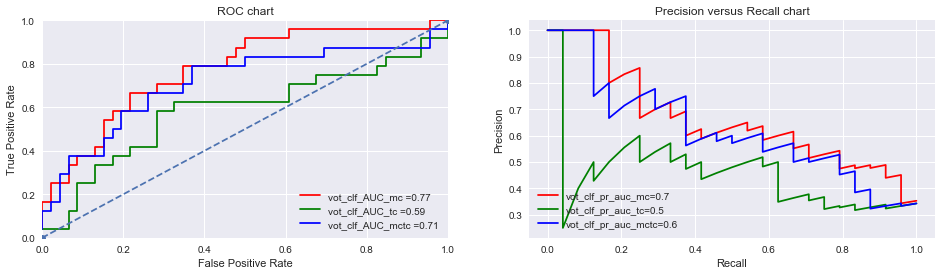

In [15]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(vot_clf_fpr_mc, vot_clf_tpr_mc, 'r', label='vot_clf_AUC_mc =%0.2f'% vot_clf_roc_auc_mc)
plt.plot(vot_clf_fpr_tc, vot_clf_tpr_tc, 'g', label='vot_clf_AUC_tc =%0.2f'% vot_clf_roc_auc_tc)
plt.plot(vot_clf_fpr_mctc, vot_clf_tpr_mctc, 'b', label='vot_clf_AUC_mctc =%0.2f'% vot_clf_roc_auc_mctc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(vot_clf_recall_mc, vot_clf_precision_mc, "r", label = 'vot_clf_pr_auc_mc=%.1f' % (vot_clf_pr_auc_mc))
plt.plot(vot_clf_recall_tc, vot_clf_precision_tc, "g", label = 'vot_clf_pr_auc_tc=%.1f' % (vot_clf_pr_auc_tc))
plt.plot(vot_clf_recall_mctc, vot_clf_precision_mctc, "b", label = 'vot_clf_pr_auc_mctc=%.1f' % (vot_clf_pr_auc_mctc))
plt.legend(loc='lower left')
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.show();

**Interpretation:** mctc performs better than mc or tc alone across a range of thresholds/metrics.  However, mctc has highest specificty. 

Define best performing point of each model via precision-recall vs threshold comparison and use this point for comparison across models.

#### Precision-Recall vs Thresholds Chart - 

Use for tweaking thresholds or point of optimal performance for each model

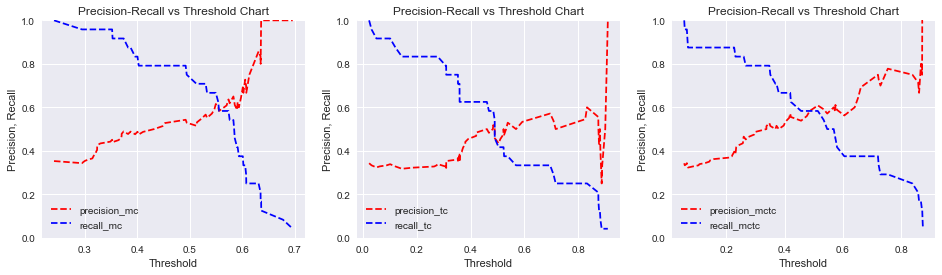

In [16]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(131)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(vot_clf_thresholds_mc, vot_clf_precision_mc[: -1], "r--", label="precision_mc")
plt.plot(vot_clf_thresholds_mc, vot_clf_recall_mc[: -1], "b--", label="recall_mc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

axes = fig.add_subplot(132)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(vot_clf_thresholds_tc, vot_clf_precision_tc[: -1], "r--", label="precision_tc")
plt.plot(vot_clf_thresholds_tc, vot_clf_recall_tc[: -1], "b--", label="recall_tc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


axes = fig.add_subplot(133)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(vot_clf_thresholds_mctc, vot_clf_precision_mctc[: -1], "r--", label="precision_mctc")
plt.plot(vot_clf_thresholds_mctc, vot_clf_recall_mctc[: -1], "b--", label="recall_mctc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


plt.show();

#### Adjust thresholds manually and re-evaluate metrics
Note: Default threshold (for classification = 1 i.e., "mostDILI" drug) is P>0.5. In below section, threshold is weakedt to <0.5 for enhancing model performance w.r.t. sensitivity and model metrics re-calculated

**Threshold>0.45**

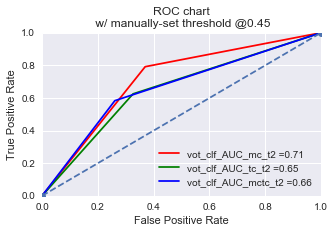

In [17]:
#Adjust threshold for each of the models
vot_clf_pred_mcy_t2=(vot_clf_mc.predict_proba(test_mcx) [:, 1]>=0.45).astype(bool)

vot_clf_pred_tcy_t2=(vot_clf_tc.predict_proba(test_tcx) [:, 1]>=0.45).astype(bool)

vot_clf_pred_mctcy_t2=(vot_clf_mctc.predict_proba(test_mctcx) [:, 1]>=0.45).astype(bool)

#plot ROC curve based on adjusted thresholds )using predicitons instead of probabilities)

vot_clf_fpr_mc_t2,vot_clf_tpr_mc_t2, vot_clf_thresholds_mc_t2=roc_curve(test_mcy, vot_clf_pred_mcy_t2)
vot_clf_roc_auc_mc_t2=metrics.auc(vot_clf_fpr_mc_t2, vot_clf_tpr_mc_t2)

vot_clf_fpr_tc_t2,vot_clf_tpr_tc_t2, vot_clf_thresholds_tc_t2=roc_curve(test_tcy, vot_clf_pred_tcy_t2)
vot_clf_roc_auc_tc_t2=metrics.auc(vot_clf_fpr_tc_t2, vot_clf_tpr_tc_t2)

vot_clf_fpr_mctc_t2,vot_clf_tpr_mctc_t2, vot_clf_thresholds_mctc_t2=roc_curve(test_mctcy, vot_clf_pred_mctcy_t2)
vot_clf_roc_auc_mctc_t2=metrics.auc(vot_clf_fpr_mctc_t2, vot_clf_tpr_mctc_t2)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @0.45")
plt.plot(vot_clf_fpr_mc_t2, vot_clf_tpr_mc_t2, 'r', label='vot_clf_AUC_mc_t2 =%0.2f'% vot_clf_roc_auc_mc_t2)
plt.plot(vot_clf_fpr_tc_t2, vot_clf_tpr_tc_t2, 'g', label='vot_clf_AUC_tc_t2 =%0.2f'% vot_clf_roc_auc_tc_t2)
plt.plot(vot_clf_fpr_mctc_t2, vot_clf_tpr_mctc_t2, 'b', label='vot_clf_AUC_mctc_t2 =%0.2f'% vot_clf_roc_auc_mctc_t2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show();

In [18]:
### Accuracy, Precision, Recall with modified threshold
vot_clf_acc_mc_t2=round(metrics.accuracy_score(test_mcy, vot_clf_pred_mcy_t2), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.45: " + str(vot_clf_acc_mc_t2)+"\n")

vot_clf_cr_mc_t2=metrics.classification_report(test_mcy, vot_clf_pred_mcy_t2)
print("Classification report with mc dataset and modified threshold of P>=0.45: ")
print(vot_clf_cr_mc_t2)    
print("***************")


vot_clf_acc_tc_t2=round(metrics.accuracy_score(test_tcy, vot_clf_pred_tcy_t2), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.45: " + str(vot_clf_acc_tc_t2)+"\n")

vot_clf_cr_tc_t2=metrics.classification_report(test_tcy, vot_clf_pred_tcy_t2)
print("Classification report with tc dataset and modified threshold of P>=0.45: ")
print(vot_clf_cr_tc_t2)   
print("***************")


vot_clf_acc_mctc_t2=round(metrics.accuracy_score(test_mctcy, vot_clf_pred_mctcy_t2), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.45: " + str(vot_clf_acc_mctc_t2)+"\n")

vot_clf_cr_mctc_t2=metrics.classification_report(test_mctcy, vot_clf_pred_mctcy_t2)
print("Classification report with mctc dataset and modified threshold of P>=0.45: ")
print(vot_clf_cr_mctc_t2) 

Overall accuracy with mc dataset and modified threshold of P>=0.45: 0.69

Classification report with mc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.85      0.63      0.72        46
          1       0.53      0.79      0.63        24

avg / total       0.74      0.69      0.69        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.45: 0.66

Classification report with tc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        46
          1       0.50      0.62      0.56        24

avg / total       0.68      0.66      0.66        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.45: 0.69

Classification report with mctc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.77      0.74    

In [19]:
###Specificity with modified threshold
from sklearn.metrics import confusion_matrix

tn_mc_t2, fp_mc_t2, fn_mc_t2, tp_mc_t2 = confusion_matrix(test_mcy, vot_clf_pred_mcy_t2).ravel()
specificity_mc_t2 = tn_mc_t2 / (tn_mc_t2+fp_mc_t2)
print("Specificity for model with modified threshold and mc variables alone")
round(specificity_mc_t2,3)


tn_tc_t2, fp_tc_t2, fn_tc_t2, tp_tc_t2 = confusion_matrix(test_tcy, vot_clf_pred_tcy_t2).ravel()
specificity_tc_t2 = tn_tc_t2 / (tn_tc_t2+fp_tc_t2)
print("Specificity for model with modified threshold and tc variables alone")
round(specificity_tc_t2,3)

tn_mctc_t2, fp_mctc_t2, fn_mctc_t2, tp_mctc_t2 = confusion_matrix(test_mctcy, vot_clf_pred_mctcy_t2).ravel()
specificity_mctc_t2 = tn_mctc_t2 / (tn_mctc_t2+fp_mctc_t2)
print("specificity for model with modified threshold and mctc variables")
round(specificity_mctc_t2, 3)   

Specificity for model with modified threshold and mc variables alone


0.63

Specificity for model with modified threshold and tc variables alone


0.674

specificity for model with modified threshold and mctc variables


0.739

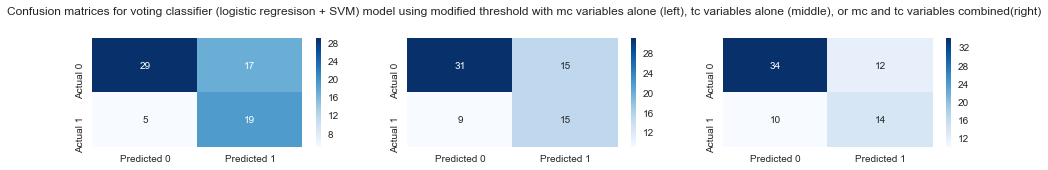

In [20]:
### Confusion Matrix with modified threshold
vot_clf_cfm_mc_t2=metrics.confusion_matrix(test_mcy, vot_clf_pred_mcy_t2)
vot_clf_cfm_tc_t2=metrics.confusion_matrix(test_tcy, vot_clf_pred_tcy_t2)
vot_clf_cfm_mctc_t2=metrics.confusion_matrix(test_mctcy, vot_clf_pred_mctcy_t2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(vot_clf_cfm_mc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(vot_clf_cfm_tc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(vot_clf_cfm_mctc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for voting classifier (logistic regresison + SVM) model using modified threshold with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

**Threshold>=0.43**

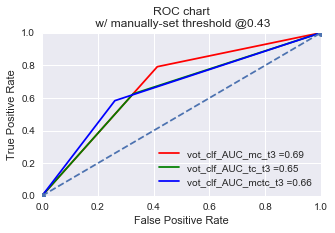

In [21]:
#Adjust threshold for each of the models
vot_clf_pred_mcy_t3=(vot_clf_mc.predict_proba(test_mcx) [:, 1]>=0.43).astype(bool)

vot_clf_pred_tcy_t3=(vot_clf_tc.predict_proba(test_tcx) [:, 1]>=0.43).astype(bool)

vot_clf_pred_mctcy_t3=(vot_clf_mctc.predict_proba(test_mctcx) [:, 1]>=0.43).astype(bool)

#plot ROC curve based on adjusted thresholds using predicitons instead of probabilities)

vot_clf_fpr_mc_t3,vot_clf_tpr_mc_t3, vot_clf_thresholds_mc_t3=roc_curve(test_mcy, vot_clf_pred_mcy_t3)
vot_clf_roc_auc_mc_t3=metrics.auc(vot_clf_fpr_mc_t3, vot_clf_tpr_mc_t3)

vot_clf_fpr_tc_t3,vot_clf_tpr_tc_t3, vot_clf_thresholds_tc_t3=roc_curve(test_tcy, vot_clf_pred_tcy_t3)
vot_clf_roc_auc_tc_t3=metrics.auc(vot_clf_fpr_tc_t3, vot_clf_tpr_tc_t3)

vot_clf_fpr_mctc_t3,vot_clf_tpr_mctc_t3, vot_clf_thresholds_mctc_t3=roc_curve(test_mctcy, vot_clf_pred_mctcy_t3)
vot_clf_roc_auc_mctc_t3=metrics.auc(vot_clf_fpr_mctc_t3, vot_clf_tpr_mctc_t3)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @0.43")
plt.plot(vot_clf_fpr_mc_t3, vot_clf_tpr_mc_t3, 'r', label='vot_clf_AUC_mc_t3 =%0.2f'% vot_clf_roc_auc_mc_t3)
plt.plot(vot_clf_fpr_tc_t3, vot_clf_tpr_tc_t3, 'g', label='vot_clf_AUC_tc_t3 =%0.2f'% vot_clf_roc_auc_tc_t3)
plt.plot(vot_clf_fpr_mctc_t3, vot_clf_tpr_mctc_t3, 'b', label='vot_clf_AUC_mctc_t3 =%0.2f'% vot_clf_roc_auc_mctc_t3)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show();   

In [22]:
### Accuracy, Precision, Recall with modified threshold (t3)
vot_clf_acc_mc_t3=round(metrics.accuracy_score(test_mcy, vot_clf_pred_mcy_t3), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.43: " + str(vot_clf_acc_mc_t3)+"\n")

vot_clf_cr_mc_t3=metrics.classification_report(test_mcy, vot_clf_pred_mcy_t3)
print("Classification report with mc dataset and modified threshold of P>=0.43: ")
print(vot_clf_cr_mc_t3)    
print("***************")


vot_clf_acc_tc_t3=round(metrics.accuracy_score(test_tcy, vot_clf_pred_tcy_t3), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.43: " + str(vot_clf_acc_tc_t3)+"\n")

vot_clf_cr_tc_t3=metrics.classification_report(test_tcy, vot_clf_pred_tcy_t3)
print("Classification report with tc dataset and modified threshold of P>=0.43: ")
print(vot_clf_cr_tc_t3)   
print("***************")


vot_clf_acc_mctc_t3=round(metrics.accuracy_score(test_mctcy, vot_clf_pred_mctcy_t3), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.43: " + str(vot_clf_acc_mctc_t3)+"\n")

vot_clf_cr_mctc_t3=metrics.classification_report(test_mctcy, vot_clf_pred_mctcy_t3)
print("Classification report with mctc dataset and modified threshold of P>=0.43: ")
print(vot_clf_cr_mctc_t3) 

Overall accuracy with mc dataset and modified threshold of P>=0.43: 0.66

Classification report with mc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.84      0.59      0.69        46
          1       0.50      0.79      0.61        24

avg / total       0.73      0.66      0.67        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.43: 0.66

Classification report with tc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        46
          1       0.50      0.62      0.56        24

avg / total       0.68      0.66      0.66        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.43: 0.69

Classification report with mctc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.77      0.74    

In [23]:
###Specificity with modified threshold (t3)
from sklearn.metrics import confusion_matrix

tn_mc_t3, fp_mc_t3, fn_mc_t3, tp_mc_t3 = confusion_matrix(test_mcy, vot_clf_pred_mcy_t3).ravel()
specificity_mc_t3 = tn_mc_t3 / (tn_mc_t3+fp_mc_t3)
print("Specificity for model with modified threshold of P>=0.43 and mc variables alone")
round(specificity_mc_t3,3)


tn_tc_t3, fp_tc_t3, fn_tc_t3, tp_tc_t3 = confusion_matrix(test_tcy, vot_clf_pred_tcy_t3).ravel()
specificity_tc_t3 = tn_tc_t3 / (tn_tc_t3+fp_tc_t3)
print("Specificity for model with modified threshold of P>=0.43 and tc variables alone")
round(specificity_tc_t3,3)

tn_mctc_t3, fp_mctc_t3, fn_mctc_t3, tp_mctc_t3 = confusion_matrix(test_mctcy, vot_clf_pred_mctcy_t3).ravel()
specificity_mctc_t3 = tn_mctc_t3 / (tn_mctc_t3+fp_mctc_t3)
print("specificity for model with modified threshold of P>=0.43 and mctc variables")
round(specificity_mctc_t3, 3)   

Specificity for model with modified threshold of P>=0.43 and mc variables alone


0.587

Specificity for model with modified threshold of P>=0.43 and tc variables alone


0.674

specificity for model with modified threshold of P>=0.43 and mctc variables


0.739

In [24]:
###The end